In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [37]:
def analisar_performance_kge(df, metric, less_is_better):
    resultados = []

    # Agrupar por Dataset para analisar cada cenário separadamente
    for dataset_name, grupo in df.groupby('dataset'):
        
        # 1. Calcular Média e Desvio Padrão
        tabela = grupo.groupby('model')[metric].agg(['mean', 'std']).reset_index()
        
        # 2. Identificar o Melhor Modelo
        if less_is_better:
            # Para Tempo: Ordena Crescente (Menor primeiro) e pega idxmin
            tabela = tabela.sort_values('mean', ascending=True)
            melhor_idx = tabela['mean'].idxmin()
        else:
            # Para MRR: Ordena Decrescente (Maior primeiro) e pega idxmax
            tabela = tabela.sort_values('mean', ascending=False)
            melhor_idx = tabela['mean'].idxmax()
            
        
        # 3. Identificar o Melhor Modelo (o mais rápido)
        melhor_modelo = tabela.iloc[0]
        amostra_melhor = grupo[grupo['model'] == melhor_modelo['model']][metric]
        
        # 4. Teste de Significância (Comparar todos contra o melhor)
        status_lista = []
        
        for i, row in tabela.iterrows():
            if i == melhor_idx: # O próprio melhor modelo
                status_lista.append("Melhor (Referência)")
                continue
            
            # Pegar as execuções do modelo atual
            amostra_atual = grupo[grupo['model'] == row['model']][metric]
            
            # Teste T de Student (independente)
            # p_value < 0.05 rejeita a hipótese nula (ou seja, a diferença É relevante)
            # p_value >= 0.05 não rejeita a nula (ou seja, é um empate estatístico)
            u_stat, p_value = stats.mannwhitneyu(amostra_melhor, amostra_atual, alternative='two-sided')
            
            if p_value >= 0.05:
                status_lista.append("Empate Técnico")
            else:
                status_lista.append("Estatisticamente Pior")
        
        tabela['dataset'] = dataset_name
        tabela['status'] = status_lista
        
        # Reordenar colunas para leitura fácil
        tabela = tabela[['dataset', 'model', 'mean', 'std', 'status']]
        
        resultados.append(tabela)

    # Juntar todos os resultados
    final_df = pd.concat(resultados, ignore_index=True)
    # 1. Aplicar ordem dos Datasets
    final_df['dataset'] = pd.Categorical(
        final_df['dataset'], 
        categories=col_order, 
        ordered=True
    )
    # 2. Aplicar ordem dos Modelos
    final_df['model'] = pd.Categorical(
        final_df['model'], 
        categories=order, 
        ordered=True
    )

    # 3. Ordenar final: Primeiro por Dataset, depois por Modelo (ambos na sua ordem)
    final_df = final_df.sort_values(['dataset', 'model'])
    return gerar_matriz_artigo(final_df)

def gerar_matriz_artigo(df_analisado):
    df = df_analisado.copy()

    def formatar_celula(row): 
        # Define o símbolo baseada na significância estatística
        # Se for o Melhor ou Empate Técnico = "+" e "-" se for Estatisticamente Pior =
        simbolo = "+" if row['status'] != "Estatisticamente Pior" else "-"
        
        # Formata: Média ±Desvio Símbolo
        return f"{row['mean']:.3f} ±{row['std']:.3f} {simbolo}"

    # 1. Criar a coluna formatada
    df['celula_final'] = df.apply(formatar_celula, axis=1)
    # 2. Pivotar a tabela (Linhas=Dataset, Colunas=Model)
    # Como as colunas 'dataset' e 'model' já são Categóricas (do passo anterior), o pivot vai respeitar automaticamente a ordem.
    tabela_pivot = df.pivot(index='dataset', columns='model', values='celula_final')
    return tabela_pivot


In [ ]:
data = pd.concat([pd.read_csv('results/v_18_a.csv'), pd.read_csv('results/v_18_c.csv'), pd.read_csv('results/v_18_d.csv'), pd.read_csv('results/v_18_e.csv'),pd.read_csv('results/v_18_f.csv')], ignore_index=True)
data.head(20)
data['inference_time'] = data['inference_time'] * 1000


,model,dataset,seed,epochs,train_time,eval_time,inference_time,mrr,hits@1,hits@3,hits@5,hits@10,gpu_mem_avg_MB,gpu_mem_peak_MB,gpu_util_avg_%,gpu_util_peak_%,gpu_power_avg_W,gpu_power_peak_W,gpu_energy_Wh
0,ConvE,FB15k-237,2,50,869.997718,11.005462,0.000257,0.003428,0.000538,0.001443,0.001982,0.003523,1146.316568,23505.1875,40.658760,100,117.336100,357.483,28.444226
1,RotatE,WN18RR,2,50,119.680347,1.249254,0.000123,0.426260,0.411081,0.430917,0.442715,0.455027,1196.069903,3851.1875,62.366524,100,177.560929,274.835,5.746069
2,ConvKB,WN18RR,2,50,118.614499,513.251597,0.000170,0.057193,0.033003,0.064808,0.080882,0.101060,18221.029546,22119.1875,89.892086,100,267.069067,291.660,46.403250
3,TransE,DBpedia50,2,50,33.006555,0.307026,0.000102,0.142352,0.037232,0.215752,0.256563,0.298568,980.377042,2009.1875,19.035948,100,93.679758,127.639,0.796278
4,DistMult,YAGO3-10,2,50,2188.752387,5.071255,0.000090,0.080321,0.044962,0.079888,0.102369,0.141509,1361.438040,21993.1875,74.450715,100,202.325253,327.687,122.299995
5,RotatE,YAGO3-10,2,50,3427.923703,7.535597,0.000123,0.154857,0.092935,0.165395,0.209554,0.277399,1835.463769,22399.1875,84.570813,100,216.642534,323.360,205.148444
6,TransE,FB15k-237,2,50,236.981975,2.128232,0.000102,0.129365,0.067423,0.138003,0.178809,0.249682,1026.372306,22257.1875,15.144259,100,84.348937,323.974,5.489710
7,ConvE,DBpedia50,2,50,106.902842,1.760150,0.000253,0.175584,0.117422,0.207160,0.240334,0.278043,1051.603933,2401.1875,43.783380,100,127.888445,384.194,3.804681
8,ConvE,WN18RR,2,50,287.850318,4.050993,0.000253,0.105757,0.060021,0.121238,0.153386,0.198187,1149.883061,3871.1875,52.357567,100,145.400527,383.189,11.555303
9,ConvE,YAGO3-10,2,50,5686.591186,23.283241,0.000252,0.033355,0.033119,0.033119,0.033119,0.033119,1544.914425,22291.1875,73.785970,100,183.005302,369.014,287.984261


<Axes: xlabel='None', ylabel='gpu_mem_peak_MB'>

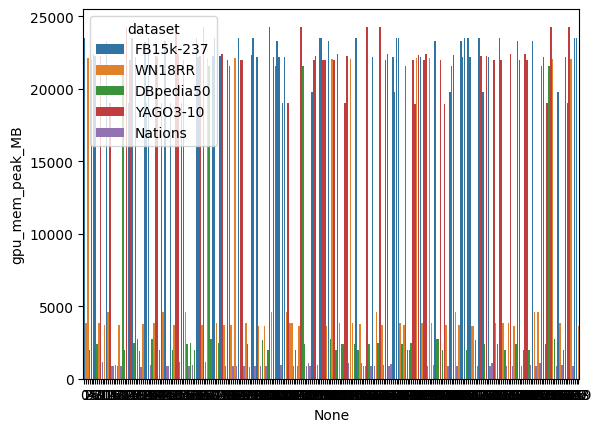

In [5]:
sns.barplot(data, x=data.index, y='gpu_mem_peak_MB', hue='dataset',)

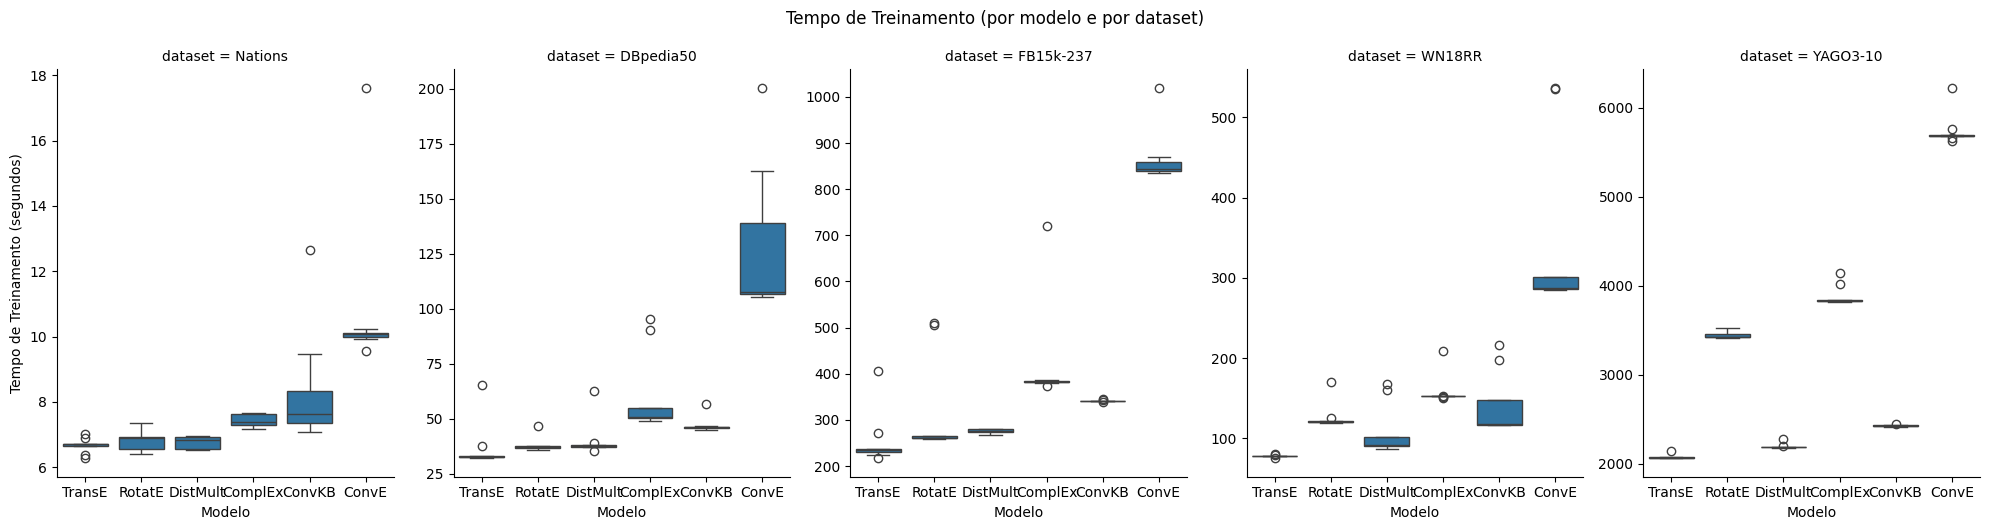

In [15]:
order = ["TransE","RotatE","DistMult","ComplEx","ConvKB","ConvE",]
col_order = ["Nations", "DBpedia50", "FB15k-237", "WN18RR", "YAGO3-10"]

titulo = "Tempo de Treinamento (por modelo e por dataset)"
g = sns.FacetGrid(data = data, col='dataset', col_order=col_order, sharey=False, height=5, aspect=0.8)
g.map(sns.boxplot, "model", "train_time", order=order)
g.fig.suptitle(titulo, y=1.05)
g.set_ylabels('Tempo de Treinamento (segundos)')
g.set_xlabels('Modelo')

# --- Execução ---
analisar_performance_kge(df=data, metric='train_time', less_is_better=True)
plt.savefig('figs/treinamento.pdf',format='pdf', bbox_inches = 'tight', dpi=300)

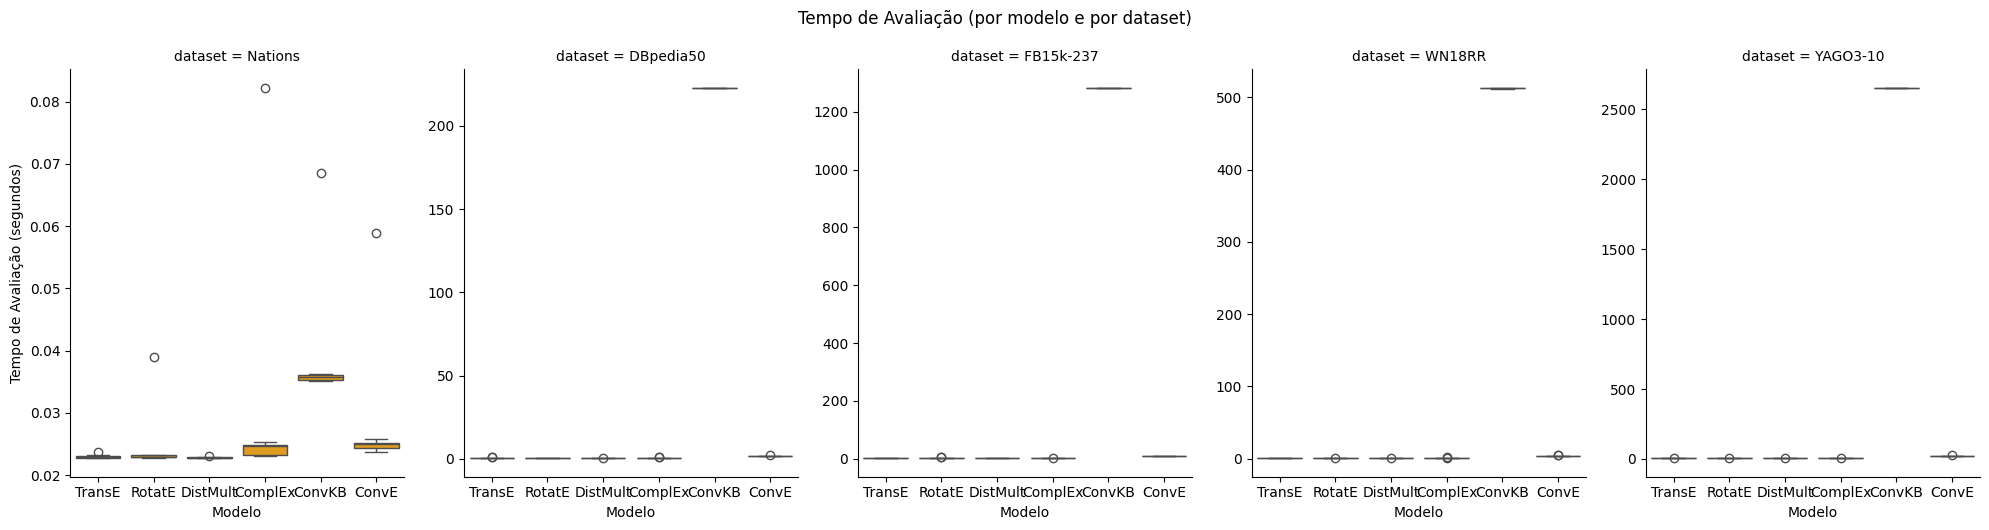

In [14]:
order = ["TransE","RotatE","DistMult","ComplEx","ConvKB","ConvE",]
col_order = ["Nations", "DBpedia50", "FB15k-237", "WN18RR", "YAGO3-10"]

titulo = "Tempo de Avaliação (por modelo e por dataset)"
g = sns.FacetGrid(data = data, col='dataset', col_order=col_order, sharey=False, height=5, aspect=0.8)
g.map(sns.boxplot, "model", "eval_time", order=order, color ='orange')
g.fig.suptitle(titulo, y=1.05)
g.set_ylabels('Tempo de Avaliação (segundos)')
g.set_xlabels('Modelo')
# --- Execução ---
analisar_performance_kge(df=data, metric='eval_time', less_is_better=True)
plt.savefig('figs/avaliação.pdf',format='pdf', bbox_inches = 'tight', dpi=300)

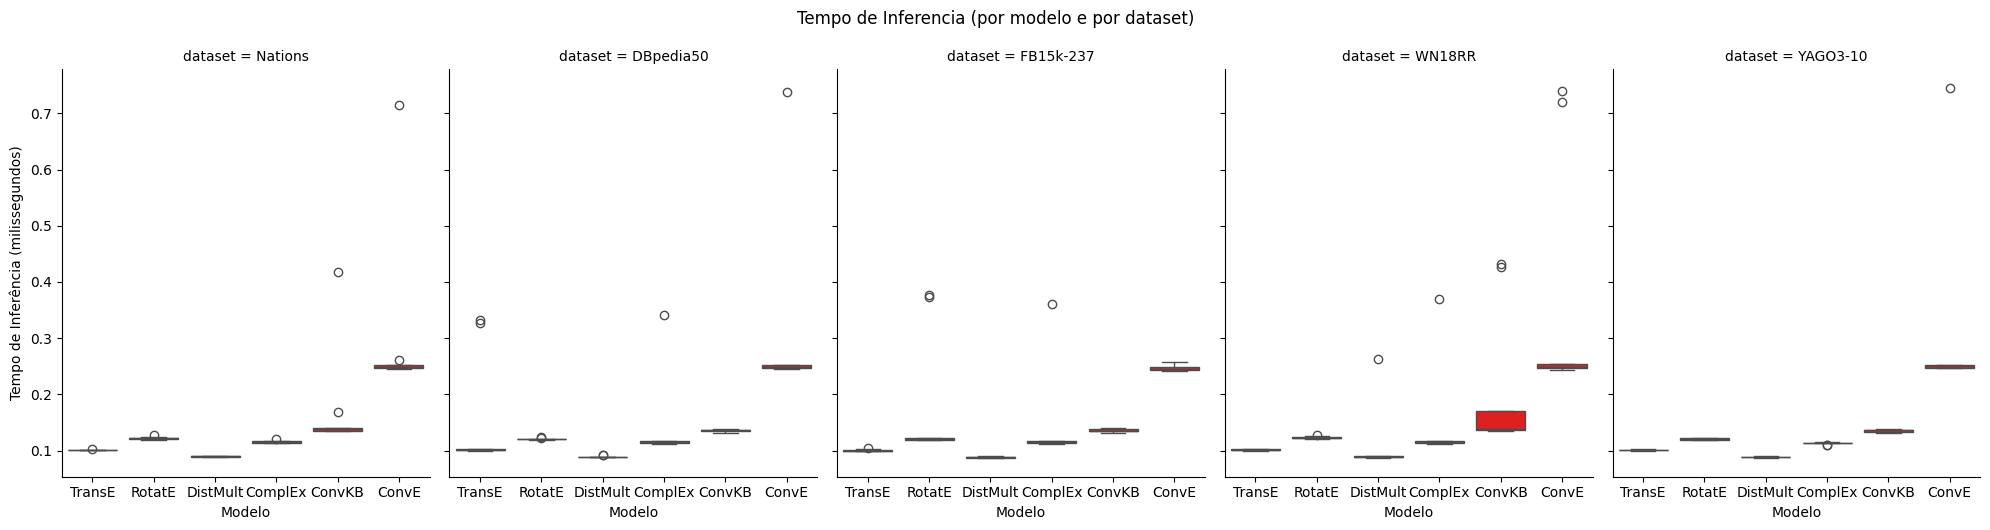

In [19]:
order = ["TransE","RotatE","DistMult","ComplEx","ConvKB","ConvE",]
col_order = ["Nations", "DBpedia50", "FB15k-237", "WN18RR", "YAGO3-10"]
#

titulo = "Tempo de Inferencia (por modelo e por dataset)"
g = sns.FacetGrid(data = data, col='dataset', col_order=col_order, sharey=True, height=5, aspect=0.8)
g.map(sns.boxplot, "model", "inference_time", order=order, color ='red')
g.fig.suptitle(titulo, y=1.05)
g.set_ylabels('Tempo de Inferência (milissegundos)')
g.set_xlabels('Modelo')

# --- Execução ---
analisar_performance_kge(df=data, metric='inference_time', less_is_better=True)
plt.savefig('figs/inferencia.pdf',format='pdf', bbox_inches = 'tight', dpi=300)

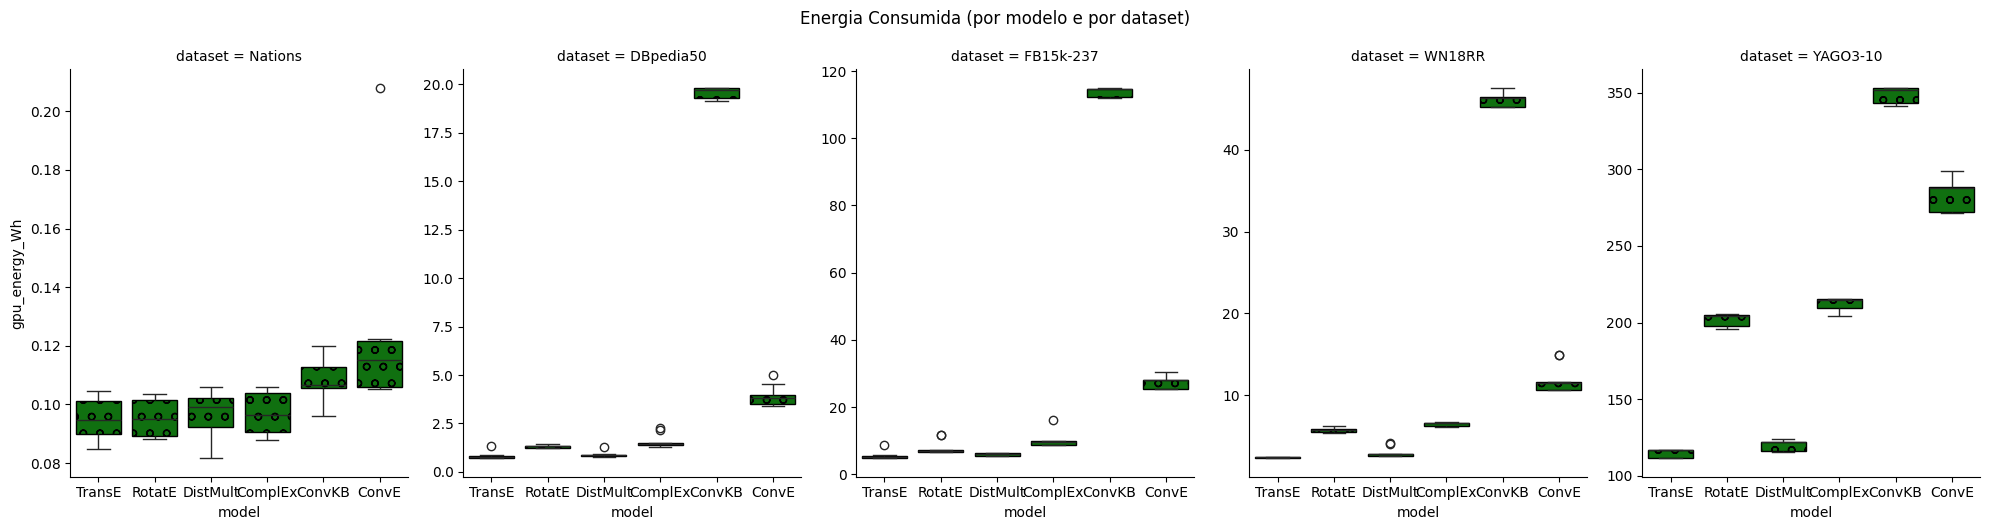

model,TransE,RotatE,DistMult,ComplEx,ConvKB,ConvE
dataset,,,,,,
Nations,0.095 ±0.008 +,0.095 ±0.006 +,0.096 ±0.008 +,0.097 ±0.007 +,0.108 ±0.008 -,0.124 ±0.032 -
DBpedia50,0.832 ±0.205 +,1.302 ±0.080 -,0.891 ±0.152 -,1.583 ±0.365 +,19.542 ±0.289 -,3.918 ±0.537 -
FB15k-237,5.571 ±1.181 +,7.937 ±2.216 -,5.943 ±0.396 -,10.015 ±2.316 +,113.604 ±1.406 -,27.226 ±1.839 -
WN18RR,2.452 ±0.071 +,5.770 ±0.283 -,3.030 ±0.628 -,6.505 ±0.231 +,46.090 ±0.921 -,11.914 ±1.743 -
YAGO3-10,114.749 ±2.642 +,201.609 ±4.143 -,119.908 ±3.370 -,211.782 ±4.503 +,348.242 ±5.293 -,282.382 ±9.965 -


In [22]:
titulo = "Energia Consumida (por modelo e por dataset)"
g = sns.FacetGrid(data = data, col='dataset', col_order=col_order, sharey=False, height=5, aspect=0.8)
g.map(sns.boxplot, "model", "gpu_energy_Wh", order=order, color ='green')
g.fig.suptitle(titulo, y=1.05)

# --- Execução ---
analisar_performance_kge(df=data, metric='gpu_energy_Wh', less_is_better=True)

# Adicionar textura de bolinhas em todas as barras
for ax in g.axes.flat:  
    for bar in ax.patches:  
        bar.set_hatch('o')   # textura de bolinhas
        bar.set_edgecolor("black")  # melhora contraste

plt.savefig('figs/consumo.pdf',format='pdf', bbox_inches = 'tight', dpi=300)
plt.show()
analisar_performance_kge(df=data, metric='gpu_energy_Wh', less_is_better=True)


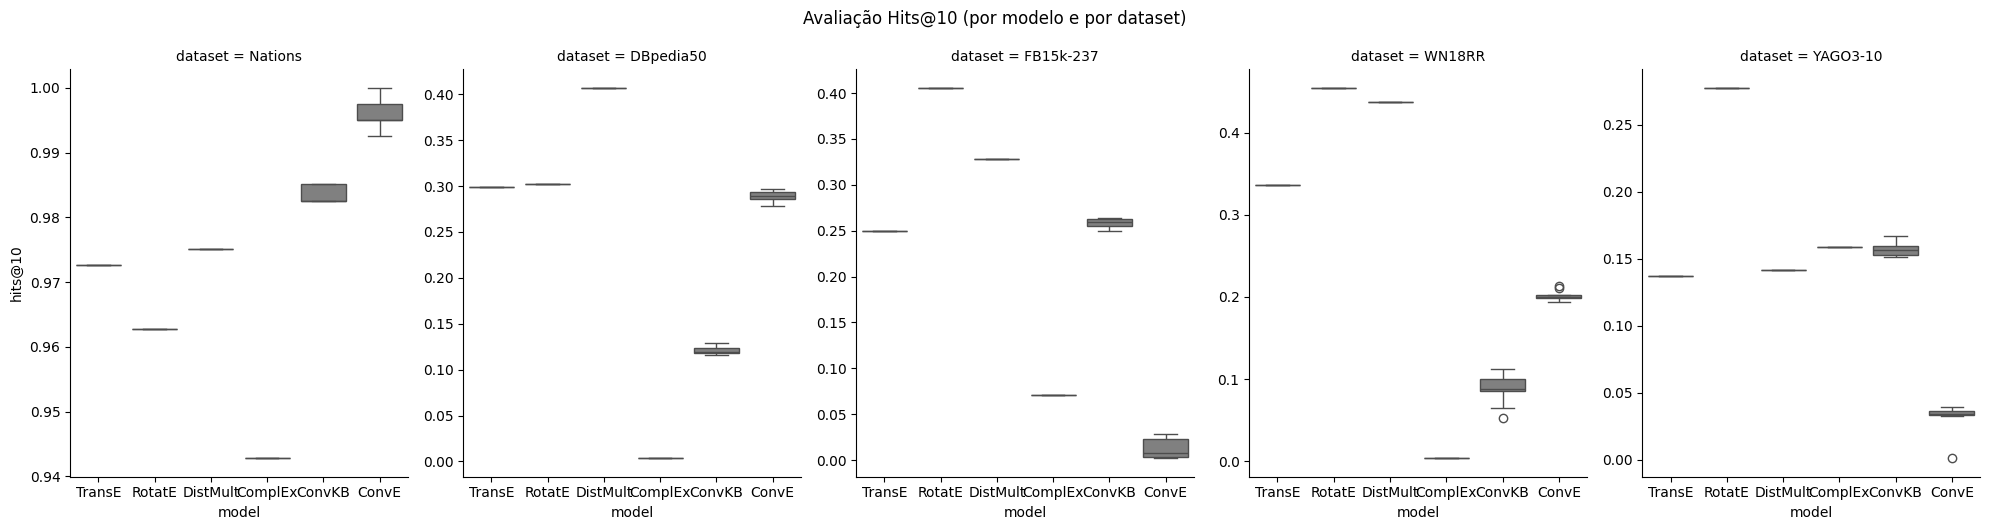

model,TransE,RotatE,DistMult,ComplEx,ConvKB,ConvE
dataset,,,,,,
Nations,0.973 ±0.000 -,0.963 ±0.000 -,0.975 ±0.000 -,0.943 ±0.000 -,0.984 ±0.001 -,0.996 ±0.002 +
DBpedia50,0.299 ±0.000 -,0.303 ±0.000 -,0.407 ±0.000 +,0.004 ±0.000 -,0.121 ±0.004 -,0.289 ±0.007 -
FB15k-237,0.250 ±0.000 -,0.406 ±0.000 +,0.329 ±0.000 -,0.071 ±0.000 -,0.259 ±0.005 -,0.012 ±0.010 -
WN18RR,0.336 ±0.000 -,0.455 ±0.000 +,0.437 ±0.000 -,0.003 ±0.000 -,0.086 ±0.018 -,0.202 ±0.006 -
YAGO3-10,0.137 ±0.000 -,0.277 ±0.000 +,0.142 ±0.000 -,0.158 ±0.000 -,0.157 ±0.005 -,0.031 ±0.011 -


In [39]:
titulo = "Avaliação Hits@10 (por modelo e por dataset)"
g = sns.FacetGrid(data = data, col='dataset', col_order=col_order, sharey=False, height=5, aspect=0.8)
g.map(sns.boxplot, "model", "hits@10", order=order, color ='gray')
g.fig.suptitle(titulo, y=1.05)

plt.show()
analisar_performance_kge(df=data, metric='hits@10', less_is_better=False)

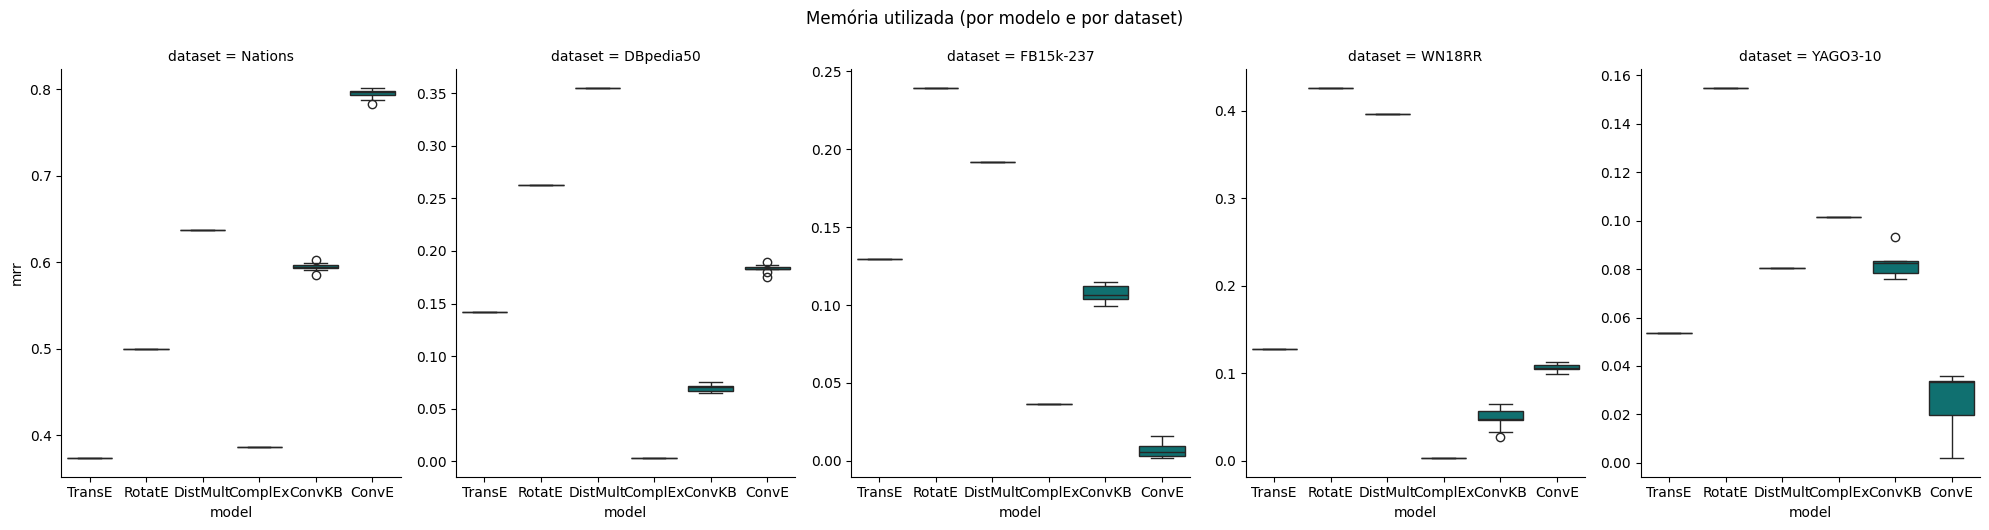

model,TransE,RotatE,DistMult,ComplEx,ConvKB,ConvE
dataset,,,,,,
Nations,0.373 ±0.000 -,0.500 ±0.000 -,0.637 ±0.000 -,0.386 ±0.000 -,0.595 ±0.005 -,0.794 ±0.006 +
DBpedia50,0.142 ±0.000 -,0.263 ±0.000 -,0.355 ±0.000 +,0.003 ±0.000 -,0.070 ±0.003 -,0.183 ±0.004 -
FB15k-237,0.129 ±0.000 -,0.239 ±0.000 +,0.192 ±0.000 -,0.037 ±0.000 -,0.107 ±0.005 -,0.007 ±0.005 -
WN18RR,0.128 ±0.000 -,0.426 ±0.000 +,0.396 ±0.000 -,0.003 ±0.000 -,0.048 ±0.012 -,0.107 ±0.004 -
YAGO3-10,0.053 ±0.000 -,0.155 ±0.000 +,0.080 ±0.000 -,0.102 ±0.000 -,0.082 ±0.005 -,0.026 ±0.012 -


In [38]:
titulo = "Memória utilizada (por modelo e por dataset)"
g = sns.FacetGrid(data = data, col='dataset', col_order=col_order, sharey=False, height=5, aspect=0.8)
g.map(sns.boxplot, "model", "mrr", order=order, color ='teal')
g.fig.suptitle(titulo, y=1.05)

# --- Execução ---
analisar_performance_kge(df=data, metric='mrr', less_is_better=True)

plt.savefig('figs/mrr.pdf',format='pdf', bbox_inches = 'tight', dpi=300)
plt.show()
analisar_performance_kge(df=data, metric='mrr', less_is_better=False)

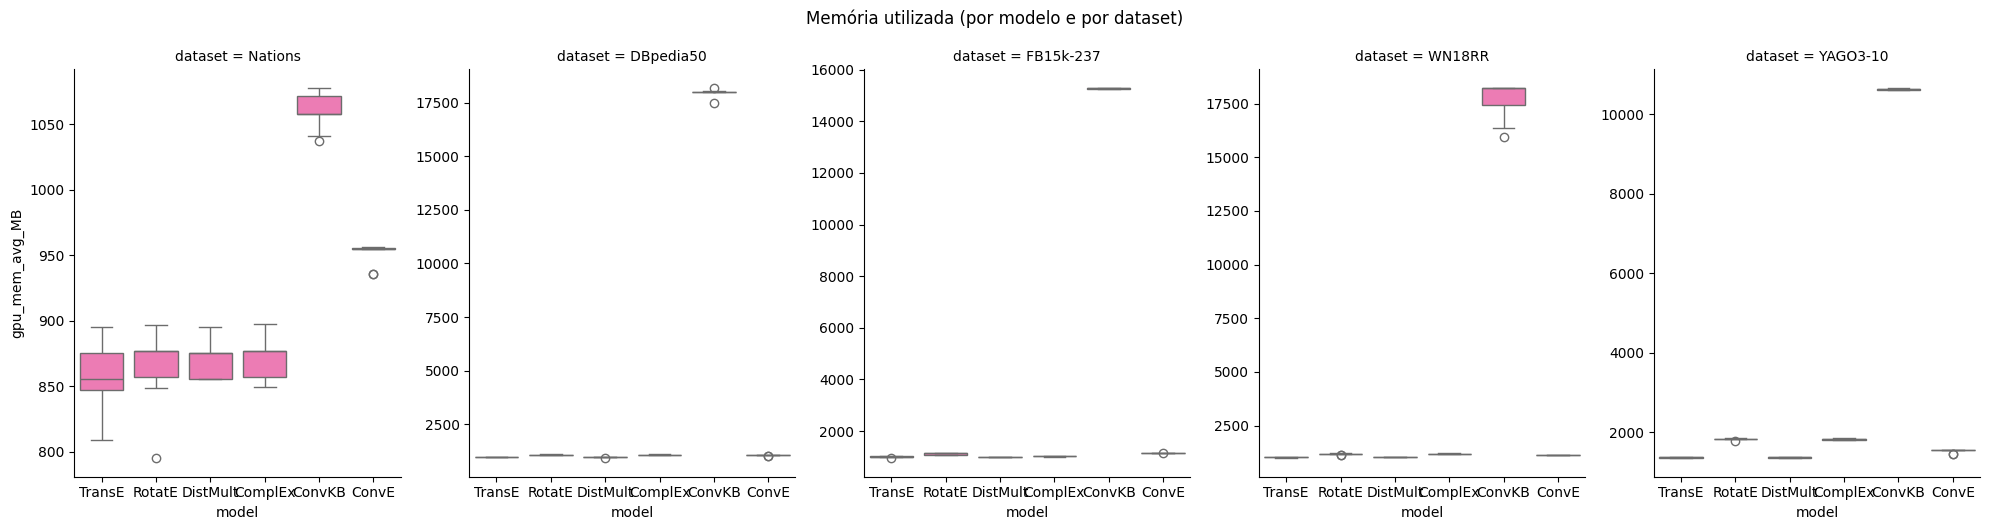

model,TransE,RotatE,DistMult,ComplEx,ConvKB,ConvE
dataset,,,,,,
Nations,861.632 ±27.088 +,864.810 ±31.199 +,870.743 ±16.667 +,871.812 ±17.780 +,1059.286 ±14.102 -,950.755 ±8.592 -
DBpedia50,967.081 ±11.475 +,1072.718 ±17.028 -,960.189 ±21.039 +,1069.577 ±19.066 +,17978.139 ±191.141 -,1045.557 ±8.579 -
FB15k-237,1004.889 ±25.336 +,1120.496 ±32.185 -,1003.982 ±4.845 +,1032.422 ±12.150 +,15272.810 ±16.452 -,1151.333 ±8.255 -
WN18RR,1022.628 ±26.487 +,1176.053 ±29.096 -,1029.702 ±10.174 +,1190.117 ±17.376 +,17675.053 ±904.511 -,1135.502 ±15.000 -
YAGO3-10,1358.472 ±16.584 +,1825.643 ±26.324 -,1357.009 ±16.474 +,1818.575 ±17.974 +,10633.883 ±17.085 -,1523.814 ±40.343 -


In [26]:
titulo = "Memória utilizada (por modelo e por dataset)"
g = sns.FacetGrid(data = data, col='dataset', col_order=col_order, sharey=False, height=5, aspect=0.8)
g.map(sns.boxplot, "model", "gpu_mem_avg_MB", order=order, color ='hotpink')
g.fig.suptitle(titulo, y=1.05)

# --- Execução ---
analisar_performance_kge(df=data, metric='gpu_mem_avg_MB', less_is_better=True)

plt.savefig('figs/memoria.pdf',format='pdf', bbox_inches = 'tight', dpi=300)
plt.show()
analisar_performance_kge(df=data, metric='gpu_mem_avg_MB', less_is_better=True)


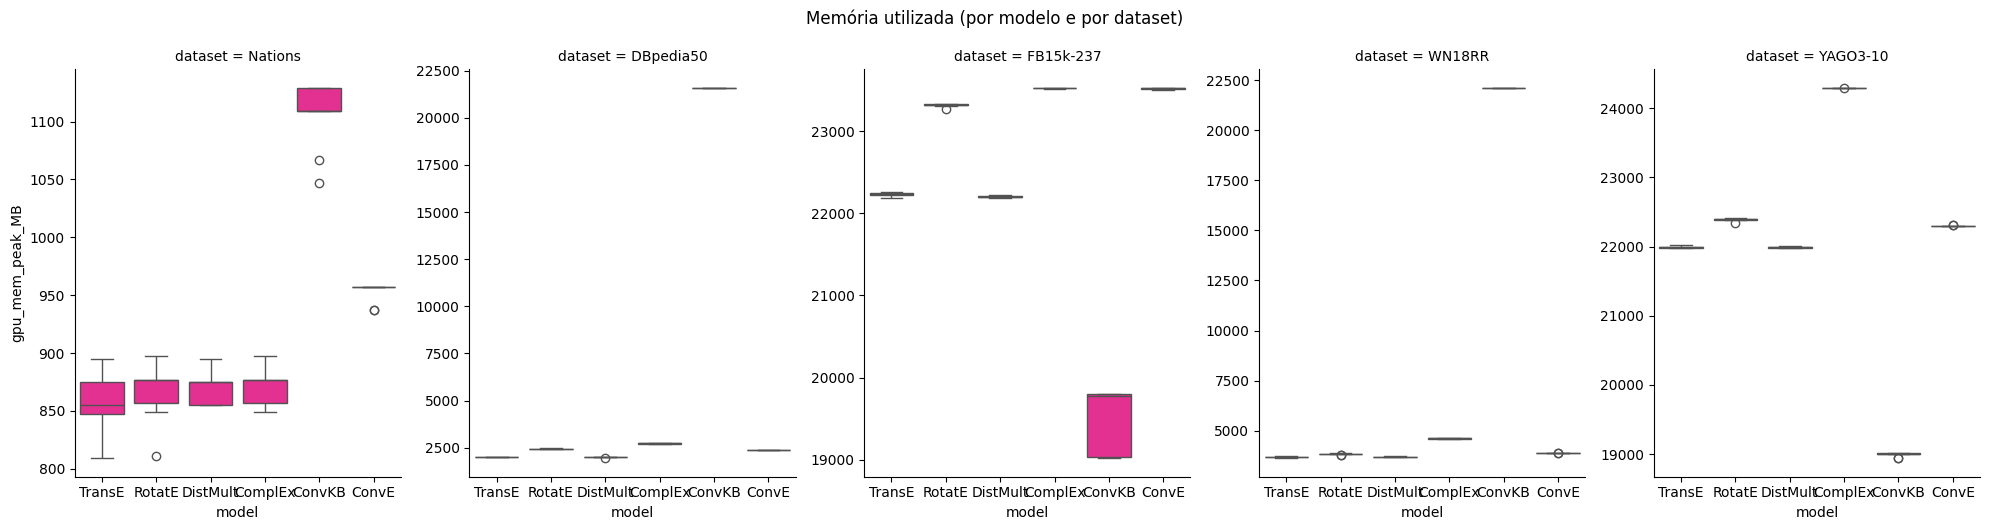

model,TransE,RotatE,DistMult,ComplEx,ConvKB,ConvE
dataset,,,,,,
Nations,861.632 ±27.088 +,866.743 ±26.829 +,870.743 ±16.667 +,871.854 ±17.776 +,1104.299 ±28.707 -,952.743 ±8.819 -
DBpedia50,1994.965 ±10.975 +,2434.743 ±16.667 -,1990.743 ±20.292 +,2726.965 ±18.774 +,21577.854 ±10.000 -,2401.188 ±0.000 -
FB15k-237,22231.632 ±19.178 -,23315.410 ±19.505 -,22202.743 ±11.738 -,23524.521 ±2.828 +,19453.632 ±402.012 +,23521.188 ±6.928 -
WN18RR,3673.632 ±32.631 +,3829.854 ±28.758 -,3683.854 ±17.776 +,4605.854 ±17.776 +,22107.632 ±9.262 -,3872.965 ±3.528 -
YAGO3-10,21990.743 ±16.667 -,22389.632 ±26.302 -,21988.743 ±16.667 -,24292.299 ±2.667 +,18989.854 ±29.103 +,22295.632 ±8.819 -


In [27]:
titulo = "Memória utilizada (por modelo e por dataset)"
g = sns.FacetGrid(data = data, col='dataset', col_order=col_order, sharey=False, height=5, aspect=0.8)
g.map(sns.boxplot, "model", "gpu_mem_peak_MB", order=order, color ='deeppink')
g.fig.suptitle(titulo, y=1.05)

# --- Execução ---
analisar_performance_kge(df=data, metric='gpu_mem_peak_MB', less_is_better=True)

plt.savefig('figs/pico_memoria.pdf',format='pdf', bbox_inches = 'tight', dpi=300)
plt.show()
analisar_performance_kge(df=data, metric='gpu_mem_peak_MB', less_is_better=True)

In [ ]:
titulo = "Tempo de Treinamento/MRR"
g = sns.FacetGrid(data = data, col='dataset', col_order=col_order, sharey=False, height=5, aspect=0.8)
g.map(sns.boxplot, "model", "gpu_mem_avg_MB", order=order, color ='hotpink')
g.fig.suptitle(titulo, y=1.05)

# --- Execução ---
analisar_performance_kge(df=data, metric='gpu_mem_avg_MB', less_is_better=True)

plt.savefig('figs/memoria.pdf',format='pdf', bbox_inches = 'tight', dpi=300)
plt.show()
analisar_performance_kge(df=data, metric='gpu_mem_avg_MB', less_is_better=True)

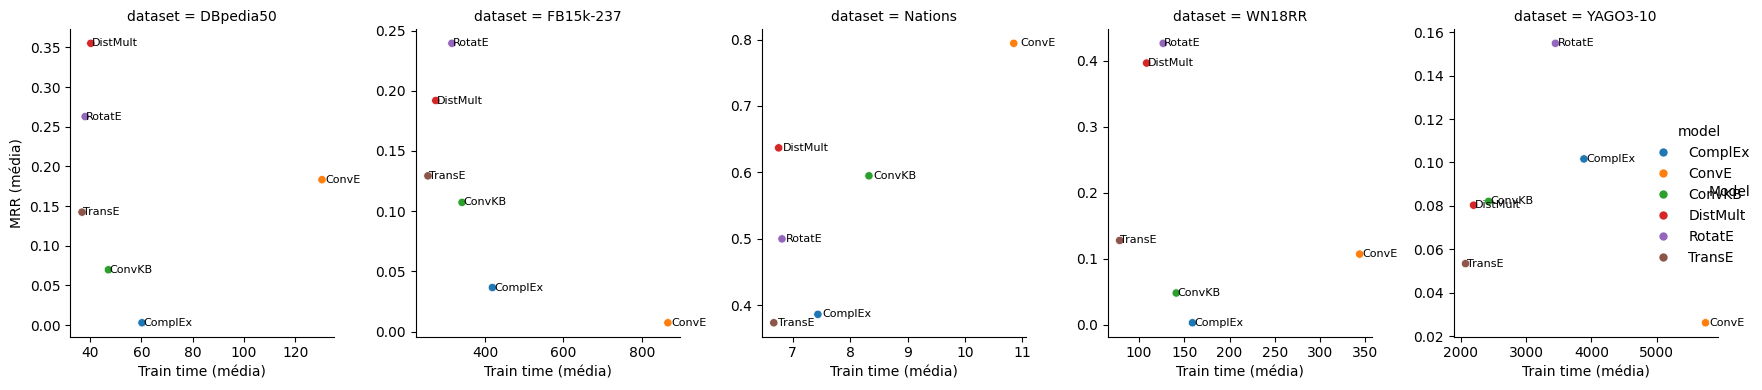

In [ ]:
# 1) Agregar média por dataset e model (um ponto por combinação)
data_agg = (
    data
    .groupby(["dataset", "model"], as_index=False)
    .agg(train_time_mean=("train_time", "mean"),
         mrr_mean=("mrr", "mean"))
)

# 2) Plot usando relplot (cria um FacetGrid internamente)
g = sns.relplot(
    data=data_agg,
    x="train_time_mean",
    y="mrr_mean",
    hue="model",
    col="dataset",
    kind="scatter",
    height=4.0,
    aspect=0.8,
    facet_kws={"sharex": False, "sharey": False}  # cada dataset com escala própria (opcional)
)

# 3) Anotar cada ponto com o nome do modelo para facilitar leitura
for ax, (dataset_name, subdf) in zip(g.axes.flatten(), data_agg.groupby("dataset")):
    for _, r in subdf.iterrows():
        # deslocamento pequeno no x para o texto não colidir com o marcador
        ax.text(r["train_time_mean"] * 1.01, r["mrr_mean"], r["model"], fontsize=8, va="center")

# Ajustes visuais
g.set_axis_labels("Train time (média)", "MRR (média)")
g.set_titles(row_template="{row_name}")   # mostra só o nome do dataset no título da faceta
g.add_legend(title="Model")

plt.tight_layout()
plt.show()

c:\Python313\Lib\site-packages\seaborn\regression.py:598: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
c:\Python313\Lib\site-packages\seaborn\regression.py:598: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


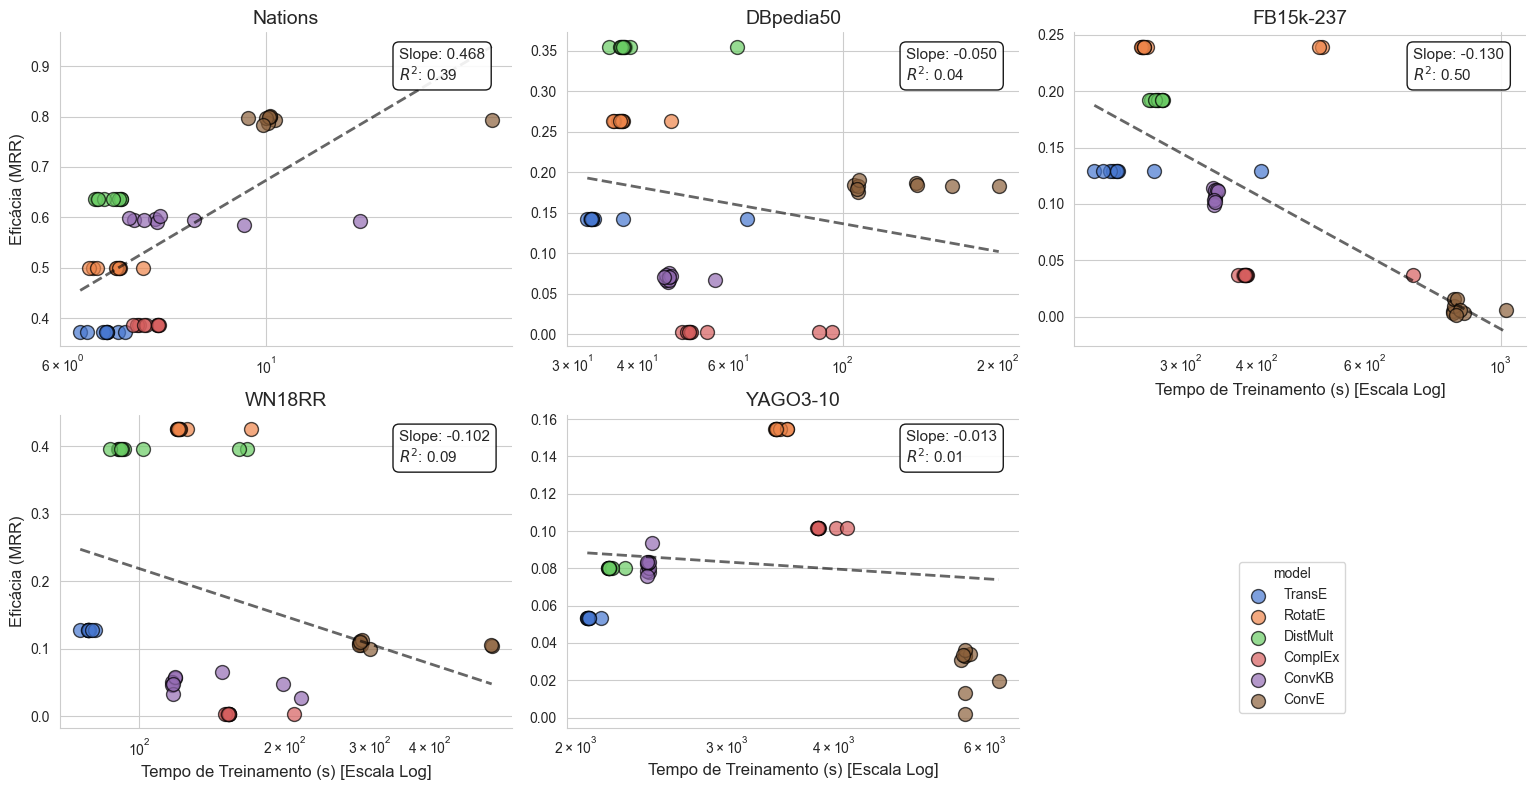

,dataset,slope,R2
0,Nations,0.468045,0.387266
1,DBpedia50,-0.049549,0.039930
2,FB15k-237,-0.129685,0.501723
3,WN18RR,-0.101782,0.087608
4,YAGO3-10,-0.012960,0.013513


In [100]:
# ---------------------------------------------------------
# 1. Configuração da Ordem e Carregamento
# ---------------------------------------------------------

# Defina a ordem exata que você quer nos gráficos e na legenda
order_model = ["TransE", "RotatE", "DistMult", "ComplEx", "ConvKB", "ConvE"]
order_dataset = ["Nations", "DBpedia50", "FB15k-237", "WN18RR", "YAGO3-10"]

# Carregue seus dados (substitua pelo caminho do seu arquivo)
# df = pd.read_csv('seu_arquivo_completo.csv')

# --- DADOS DE EXEMPLO (Para testar o código se não tiver o CSV agora) ---
# Vou recriar um dummy baseado nas suas médias para garantir que o código rode
data_mock = {
    'model': order_model * 5,
    'dataset': sorted(order_dataset * 6), # Apenas para estrutura
    'train_time': np.random.uniform(10, 1000, 30), # Valores aleatórios para teste
    'mrr': np.random.uniform(0, 1, 30)
}
# Se já tiver carregado o df, ignore a linha abaixo
# df = pd.DataFrame(data_mock) 
# ---------------------------------------------------------

# 2. Preparação: Log do Tempo
df['log_train_time'] = np.log(df['train_time'])

# ---------------------------------------------------------
# 3. Plotagem Ordenada
# ---------------------------------------------------------
sns.set_style("whitegrid")

g = sns.lmplot(
    data=df,
    x="train_time",
    y="mrr",
    col="dataset",
    hue="model",
    # --- AQUI ESTÃO AS MUDANÇAS DE ORDEM ---
    col_order=order_dataset,  # Força a ordem dos painéis (Nations -> YAGO)
    hue_order=order_model,    # Força a ordem da legenda (TransE -> ConvE)
    # ---------------------------------------
    col_wrap=3,
    height=4,
    aspect=1.2,
    sharex=False,
    sharey=False,
    ci=None,
    palette="muted", # "muted", "deep", "bright", "colorblind" são boas opções
    scatter_kws={"s": 100, "edgecolor": "black", "alpha": 0.7},
    line_kws={"alpha": 0.0}
)

# Lista para guardar os resultados estatísticos
results_stats = []

# Iteramos sobre os eixos (axes) e a lista de ordem explicitamente
# Isso garante que o gráfico do 'Nations' receba a regressão do 'Nations'
for ax, dataset_name in zip(g.axes.flat, order_dataset):
    
    # Filtra os dados específicos desse dataset
    subset = df[df['dataset'] == dataset_name]
    
    if len(subset) > 1: # Só calcula se tiver dados suficientes
        # Calcula regressão: Log(Tempo) vs MRR
        slope, intercept, r_value, p_value, std_err = stats.linregress(subset['log_train_time'], subset['mrr'])
        
        # Salva stats
        results_stats.append({'dataset': dataset_name, 'slope': slope, 'R2': r_value**2})
        
        # Cria pontos para a linha de tendência
        # Usamos min/max do tempo real para que a linha cubra todo o eixo X do gráfico
        x_vals = np.linspace(subset['train_time'].min(), subset['train_time'].max(), 100)
        y_vals = slope * np.log(x_vals) + intercept
        
        # Desenha a linha de tendência (Preta Tracejada)
        ax.plot(x_vals, y_vals, color='black', linestyle='--', linewidth=2, alpha=0.6, label='Tendência (Log-Linear)')
        
        # Adiciona a caixa de texto com Slope e R2
        # Posicionada no canto superior direito (ou esquerdo, mude x para 0.05)
        ax.text(0.75, 0.95, f'Slope: {slope:.3f}\n$R^2$: {r_value**2:.2f}', 
                transform=ax.transAxes, verticalalignment='top', fontsize=11,
                bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="black", alpha=0.9))
    
    # Ajuste para escala Log no eixo X
    ax.set_xscale('log')

# Ajustes Finais de Layout
g.set_titles("{col_name}", size=14)
g.set_axis_labels("Tempo de Treinamento (s) [Escala Log]", "Eficácia (MRR)", size=12)
# Ajuste da legenda para ficar fora ou em local apropriado se precisar
sns.move_legend(g, "upper left", bbox_to_anchor=(.80, .30), frameon=True)

plt.tight_layout()
plt.savefig('figs/regressão.pdf',format='pdf', bbox_inches = 'tight', dpi=300)

plt.show()

# Mostra a tabela de estatísticas na ordem correta
stats_df = pd.DataFrame(results_stats)
stats_df